In [1]:
import numpy as np
import os
import glob
import my_utils as myu  # Ensure 'myu' is properly defined or imported
from tqdm import tqdm
import concurrent.futures

In [2]:
# def read_all_vtks_and_interpolate(folder_path, grid_size=1.0):
#     # Updated pattern to generalize subfolder handling
#     all_vtk_files = glob.glob(os.path.join(folder_path, 'outputs/*.vtk'))

#     file_details = [(file, int(file.split('_')[-1].split('.')[0])) for file in all_vtk_files]
#     file_details_sorted = sorted(file_details, key=lambda x: x[1])

#     if not file_details_sorted:
#         raise ValueError("No VTK files found in the specified folder.")

#     # Determine the maximum file number dynamically
#     max_file_number = file_details_sorted[-1][1]

#     early_files = [file for file, num in file_details_sorted if 0 <= num <= 150000]
#     later_files = [file for file, num in file_details_sorted if 150001 <= num <= max_file_number]
#     early_selected = np.linspace(0, len(early_files) - 1, 5, dtype=int)
#     later_selected = np.linspace(0, len(later_files) - 1, 15, dtype=int)
#     vtk_files = [early_files[i] for i in early_selected] + [later_files[i] for i in later_selected]

#     total_files = len(vtk_files)
#     all_data = []

#     # for filename in tqdm(vtk_files, desc='Reading VTK files', unit='file'):
#     #     data = myu.read_mesh_cellCon(filename, 1, 0)
#     #     all_data.append(data)
#     folder_name = os.path.basename(folder_path)
    
#     for filename in tqdm(vtk_files, desc=f'Reading VTK files from {folder_name}', unit='file'):
#         data = myu.read_mesh_cellCon(filename, 1, 0)
#         all_data.append(data)

#     last_data_points = myu.read_mesh_cellCon(vtk_files[-1], 1, 0)[0]
#     min_x, min_y = np.min(last_data_points, axis=0)
#     max_x, max_y = np.max(last_data_points, axis=0)
#     x_coords = np.arange(min_x, max_x + grid_size, grid_size)
#     y_coords = np.arange(min_y, max_y + grid_size, grid_size)
#     grid_x, grid_y = np.meshgrid(x_coords, y_coords)
#     grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

#     last_theta = myu.read_mesh_cellCon(vtk_files[-1], 1, 0)[1]['theta']
#     interpolated_theta = myu.interpolate_features(last_data_points, {'theta': last_theta}, grid_points, k=3)['theta']

#     time_step_data = []
#     print("Starting interpolation of data across all files.")
#     for file_index, data in enumerate(tqdm(all_data, desc=f'Interpolating data from {os.path.basename(folder_path)}', unit='file')):
#         unique_points = data[0]
#         interpolated_step_data = {'theta': interpolated_theta.reshape(len(y_coords), len(x_coords))}
#         for field_name, values in data[1].items():
#             if field_name != 'theta':
#                 interpolated_values = myu.interpolate_features(unique_points, {field_name: values}, grid_points, k=3)
#                 interpolated_matrix = interpolated_values[field_name].reshape(len(y_coords), len(x_coords))
#                 interpolated_step_data[field_name] = interpolated_matrix      
#     # time_step_data = []
#     # print("Starting interpolation of data across all files.")
#     # # for file_index, data in enumerate(tqdm(all_data, desc='Interpolating data', unit='file')):
#     # with tqdm(all_data, desc=f'Interpolating data from {folder_name}', unit='file') as pbar:
#     #     unique_points = data[0]
#     #     interpolated_step_data = {'theta': interpolated_theta.reshape(len(y_coords), len(x_coords))}
#     #     for field_name, values in data[1].items():
#     #         if field_name != 'theta':
#     #             interpolated_values = myu.interpolate_features(unique_points, {field_name: values}, grid_points, k=3)
#     #             interpolated_matrix = interpolated_values[field_name].reshape(len(y_coords), len(x_coords))
#     #             interpolated_step_data[field_name] = interpolated_matrix

#         time_step_data.append(interpolated_step_data)

#     print("All files processed and interpolated.")
#     return time_step_data, grid_x, grid_y

# def process_all_cases(base_path):
#     cases_data = {}
#     subfolders = glob.glob(os.path.join(base_path, 'io2D_*'))
#     print(subfolders)
    
#     # Set up ThreadPoolExecutor to manage threads
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         # Create a future object for each folder processing task
#         future_to_subfolder = {executor.submit(read_all_vtks_and_interpolate, subfolder, 1.0): subfolder for subfolder in subfolders}
        
#         # Collect results as they are completed
#         for future in concurrent.futures.as_completed(future_to_subfolder):
#             subfolder = future_to_subfolder[future]
#             case_name = os.path.basename(subfolder)
#             try:
#                 time_step_interpolated_data, grid_x, grid_y = future.result()
#                 cases_data[case_name] = (time_step_interpolated_data, grid_x, grid_y)
#                 print(f"Processed {subfolder}...")
#             except Exception as exc:
#                 print(f"{subfolder} generated an exception: {exc}")

#     return cases_data

In [3]:
import numpy as np
import glob
import os
from tqdm import tqdm
import re
# import concurrent.futures
import my_utils as myu  # Ensure 'myu' is defined with necessary functions

def find_global_bounds(subfolders):
    """Calculate global bounds based on the 30th VTK file in the later files across all subfolders."""
    global_min_x, global_min_y = float('inf'), float('inf')
    global_max_x, global_max_y = float('-inf'), float('-inf')

    for subfolder in tqdm(subfolders, desc="Calculating global bounds"):
        vtk_files = glob.glob(os.path.join(subfolder, 'outputs/*.vtk'))
        file_details = [(file, int(file.split('_')[-1].split('.')[0])) for file in vtk_files]
        file_details_sorted = sorted(file_details, key=lambda x: x[1])

        # Focus only on files beyond the 150000 index
        later_files = [file for file, num in file_details_sorted if 150001 <= num]
        if later_files:
            # Ensure we have at least 20 files to choose from, then select the last (30th frame)
            if len(later_files) >= 20:
                later_selected = [later_files[i] for i in np.linspace(0, len(later_files) - 1, 20, dtype=int)]
                last_file = later_selected[-1]  # The 30th file from later selected
                data = myu.read_mesh_cellCon(last_file, 1, 0)
                if data:
                    points = data[0]
                    min_x, min_y = np.min(points, axis=0)
                    max_x, max_y = np.max(points, axis=0)
                    # Update global bounds across all subfolders
                    # global_min_x = min(global_min_x, min_x)
                    # global_min_y = min(global_min_y, min_y)
                    # global_max_x = max(global_max_x, max_x)
                    # global_max_y = max(global_max_y, max_y)

                    global_min_x = min(min(global_min_y, min(global_min_x, min_x)), min_y)
                    global_min_y = global_min_x
                    global_max_x = max(max(global_max_y, max(global_max_x, max_x)), max_y)
                    global_max_y = global_max_x

    return global_min_x, global_min_y, global_max_x, global_max_y

def interpolate_data_for_folder(folder_path, global_bounds, grid_size=1.0):
    """Interpolate selected VTK files within a folder using specified global bounds, with progress output."""
    global_min_x, global_min_y, global_max_x, global_max_y = global_bounds
    x_coords = np.arange(global_min_x, global_max_x + grid_size, grid_size)
    y_coords = np.arange(global_min_y, global_max_y + grid_size, grid_size)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

    interpolated_data = []
    all_vtk_files = glob.glob(os.path.join(folder_path, 'outputs/*.vtk'))
    file_details = [(file, int(file.split('_')[-1].split('.')[0])) for file in all_vtk_files]
    file_details_sorted = sorted(file_details, key=lambda x: x[1])
    
    # Assuming file_details_sorted is available from your code logic
    early_files = [file for file, num in file_details_sorted if num <= 150000]
    later_files = [file for file, num in file_details_sorted if num >= 150001]
    # Select a limited number of files (if enough exist)
    early_selected = [early_files[i] for i in np.around(np.linspace(0, len(early_files) - 1, min(10, len(early_files)), dtype=int)).astype(int)]
    # Adjust the selection logic for later files using np.around to avoid floating-point precision issues
    if len(later_files) > 0:
        later_selected = [later_files[i] for i in np.around(np.linspace(0, len(later_files) - 1, min(20, len(later_files)), dtype=int)).astype(int)]
    else:
        later_selected = []
        raise ValueError("No files found with numbers >= 150001")
    selected_files = early_selected + later_selected
    
    folder_name = os.path.basename(folder_path)
    desc = f'Interpolating in {folder_name}'

    with tqdm(total=len(selected_files), desc=desc, unit='file') as progress:
        for filename in selected_files:
            data = myu.read_mesh_cellCon(filename, 1, 0)
            if data:
                points, fields, _, _ = data
                interpolated_step_data = {}
                for field_name, values in fields.items():
                    interpolated_values = myu.interpolate_features_cKD(points, {field_name: values}, grid_points, k=3)
                    interpolated_matrix = interpolated_values[field_name].reshape(len(y_coords), len(x_coords))
                    interpolated_step_data[field_name] = interpolated_matrix
                interpolated_data.append(interpolated_step_data)
            progress.update(1)

    return interpolated_data, grid_x, grid_y

def process_all_cases(base_path):
    subfolders = glob.glob(os.path.join(base_path, 'io2D_ND0*'))

    # Sort subfolders based on the numeric part of the folder name
    subfolders.sort(key=lambda x: int(re.search(r'ND(\d+)', os.path.basename(x)).group(1)))

    global_bounds = find_global_bounds(subfolders)
    cases_data = {}

    for subfolder in subfolders:
        interpolated_data, grid_x, grid_y = interpolate_data_for_folder(subfolder, global_bounds)
        case_name = os.path.basename(subfolder)
        cases_data[case_name] = (interpolated_data, grid_x, grid_y)

    return cases_data

# root_folder_path = "/mnt/e/NeuronGrowth_2024/TTNG_05052024"
root_folder_path = "/mnt/e/GenNDD_data"
all_cases_data = process_all_cases(root_folder_path)

Calculating global bounds:   0%|          | 0/8 [00:00<?, ?it/s]

Interpolating in io2D_ND09: 100%|██████████| 30/30 [00:30<00:00,  1.02s/file]


In [10]:
import numpy as np
from scipy.ndimage import zoom

def downsample_all_cases_data(all_cases_data, target_size=(160, 280)):
    """
    Downsamples each dataset from (241, 241) to (160, 280) for each image and the grid in all_cases_data.

    Args:
    all_cases_data (dict): Dictionary with keys as case identifiers and values as tuples of
                           (interpolated_data, grid_x, grid_y) where interpolated_data is a list of dictionaries
                           of shape (#time, #channel, 241, 241).
    target_size (tuple): Target downsample size, default (160, 280).

    Returns:
    dict: A dictionary with the same keys and downsampled data as values. Each case will have:
          (downsampled_interpolated_data, downsampled_grid_x, downsampled_grid_y).
    """
    downsampled_data = {}

    for key, (interpolated_data, grid_x, grid_y) in all_cases_data.items():
        time_steps = len(interpolated_data)
        channels = interpolated_data[0].keys()  # Assuming all time steps have the same channels
        downsampled_tensor = []

        # Downsample the grid_x and grid_y to (160, 280)
        zoom_factor_grid_x = target_size[0] / grid_x.shape[0]
        zoom_factor_grid_y = target_size[1] / grid_y.shape[1]
        downsampled_grid_x = zoom(grid_x, zoom_factor_grid_x, order=1)  # Bilinear interpolation
        downsampled_grid_y = zoom(grid_y, zoom_factor_grid_y, order=1)

        # Downsample the interpolated_data (each time step and channel)
        for time_step in interpolated_data:
            downsampled_channels = {}
            for channel in channels:
                image = time_step[channel]  # Get the image for this channel
                # Calculate the zoom factor for the image
                zoom_factor_image_x = target_size[0] / image.shape[0]
                zoom_factor_image_y = target_size[1] / image.shape[1]
                # Downsample the image
                downsampled_image = zoom(image, (zoom_factor_image_x, zoom_factor_image_y), order=1)  # Bilinear interpolation (order=1)
                downsampled_channels[channel] = downsampled_image
            downsampled_tensor.append(downsampled_channels)

        # Store the downsampled data for this case
        downsampled_data[key] = (downsampled_tensor, downsampled_grid_x, downsampled_grid_y)

    return downsampled_data

# Example usage
# Assuming `all_cases_data` is your loaded dataset
all_cases_data = downsample_all_cases_data(all_cases_data, target_size=(160, 280))

In [11]:
def check_consistent_dimensions_all_channels(all_cases_data):
    """
    Check if the dimensions of all channels are consistent across all cases in the dataset.

    Args:
        all_cases_data (dict): Dictionary containing all cases.

    Returns:
        bool: True if dimensions are consistent for all channels, False otherwise.
    """

    # Initialize a variable to store reference shapes for all channels
    reference_shapes = None

    for case, case_data in all_cases_data.items():
        try:
            current_shapes = {channel: case_data[0][0][channel].shape for channel in case_data[0][0]}  # Get shapes for all channels
            
            # Set the first case's shapes as the reference
            if reference_shapes is None:
                reference_shapes = current_shapes
            # Compare the current shapes with the reference shapes
            else:
                for channel, current_shape in current_shapes.items():
                    if channel in reference_shapes:
                        if current_shape != reference_shapes[channel]:
                            print(f"Warning: Shape of '{channel}' in {case} is inconsistent. Expected {reference_shapes[channel]}, but got {current_shape}.")
                            return False
                    else:
                        print(f"Warning: Channel '{channel}' found in {case} but missing in the reference case.")
                        return False
        except KeyError:
            print(f"Warning: Some channels are missing in {case}.")
            return False

    print(f"All cases have consistent dimensions for all channels.")
    return True

def print_all_cases_data_dimensions(all_cases_data):
    """
    Prints the dimensions of the data stored in all_cases_data.

    Args:
        all_cases_data (dict): Dictionary containing data for all cases. 
                               Each case is a tuple with (interpolated_data, grid_x, grid_y).

    Returns:
        None
    """
    for case_name, (interpolated_data, grid_x, grid_y) in all_cases_data.items():
        print(f"Case: {case_name}")
        # Print dimensions of interpolated_data
        if isinstance(interpolated_data, list):
            print(f"  Interpolated Data: {len(interpolated_data)} time steps")
            if len(interpolated_data) > 0 and isinstance(interpolated_data[0], dict):
                for channel, data_array in interpolated_data[0].items():
                    print(f"    Channel '{channel}': {data_array.shape}")
        else:
            print(f"  Interpolated Data: {interpolated_data.shape}")

        # Print dimensions of grid_x and grid_y
        print(f"  Grid X: {grid_x.shape}")
        print(f"  Grid Y: {grid_y.shape}")
        print("-" * 50)

print_all_cases_data_dimensions(all_cases_data)
consistent = check_consistent_dimensions_all_channels(all_cases_data)

Case: io2D_ND01
  Interpolated Data: 30 time steps
    Channel 'phi': (160, 280)
    Channel 'synaptogenesis': (160, 280)
    Channel 'tubulin': (160, 280)
    Channel 'tips': (160, 280)
    Channel 'theta': (160, 280)
  Grid X: (160, 160)
  Grid Y: (280, 280)
--------------------------------------------------
Case: io2D_ND03
  Interpolated Data: 30 time steps
    Channel 'phi': (160, 280)
    Channel 'synaptogenesis': (160, 280)
    Channel 'tubulin': (160, 280)
    Channel 'tips': (160, 280)
    Channel 'theta': (160, 280)
  Grid X: (160, 160)
  Grid Y: (280, 280)
--------------------------------------------------
Case: io2D_ND04
  Interpolated Data: 30 time steps
    Channel 'phi': (160, 280)
    Channel 'synaptogenesis': (160, 280)
    Channel 'tubulin': (160, 280)
    Channel 'tips': (160, 280)
    Channel 'theta': (160, 280)
  Grid X: (160, 160)
  Grid Y: (280, 280)
--------------------------------------------------
Case: io2D_ND05
  Interpolated Data: 30 time steps
    Channel '

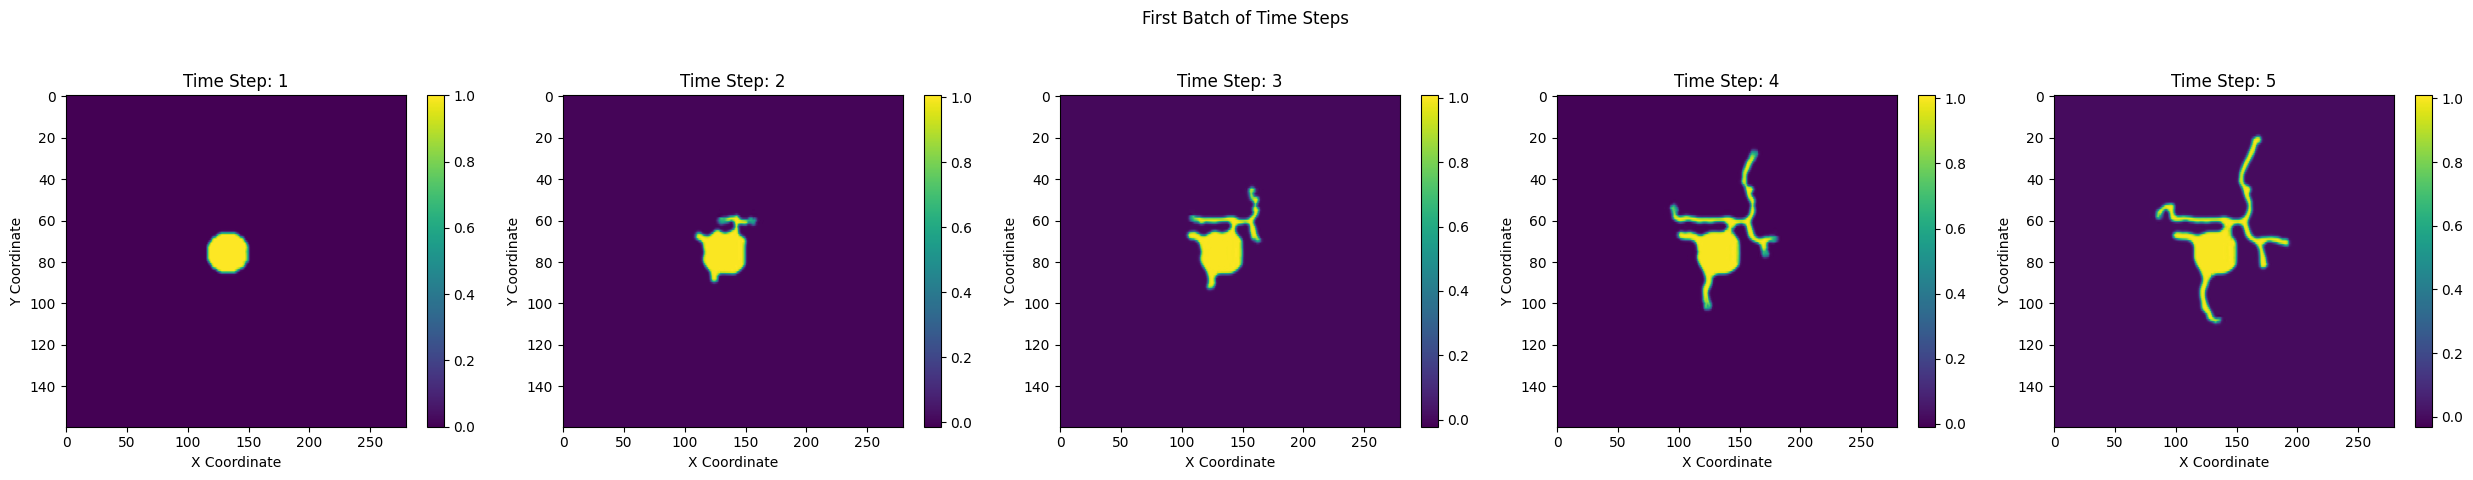

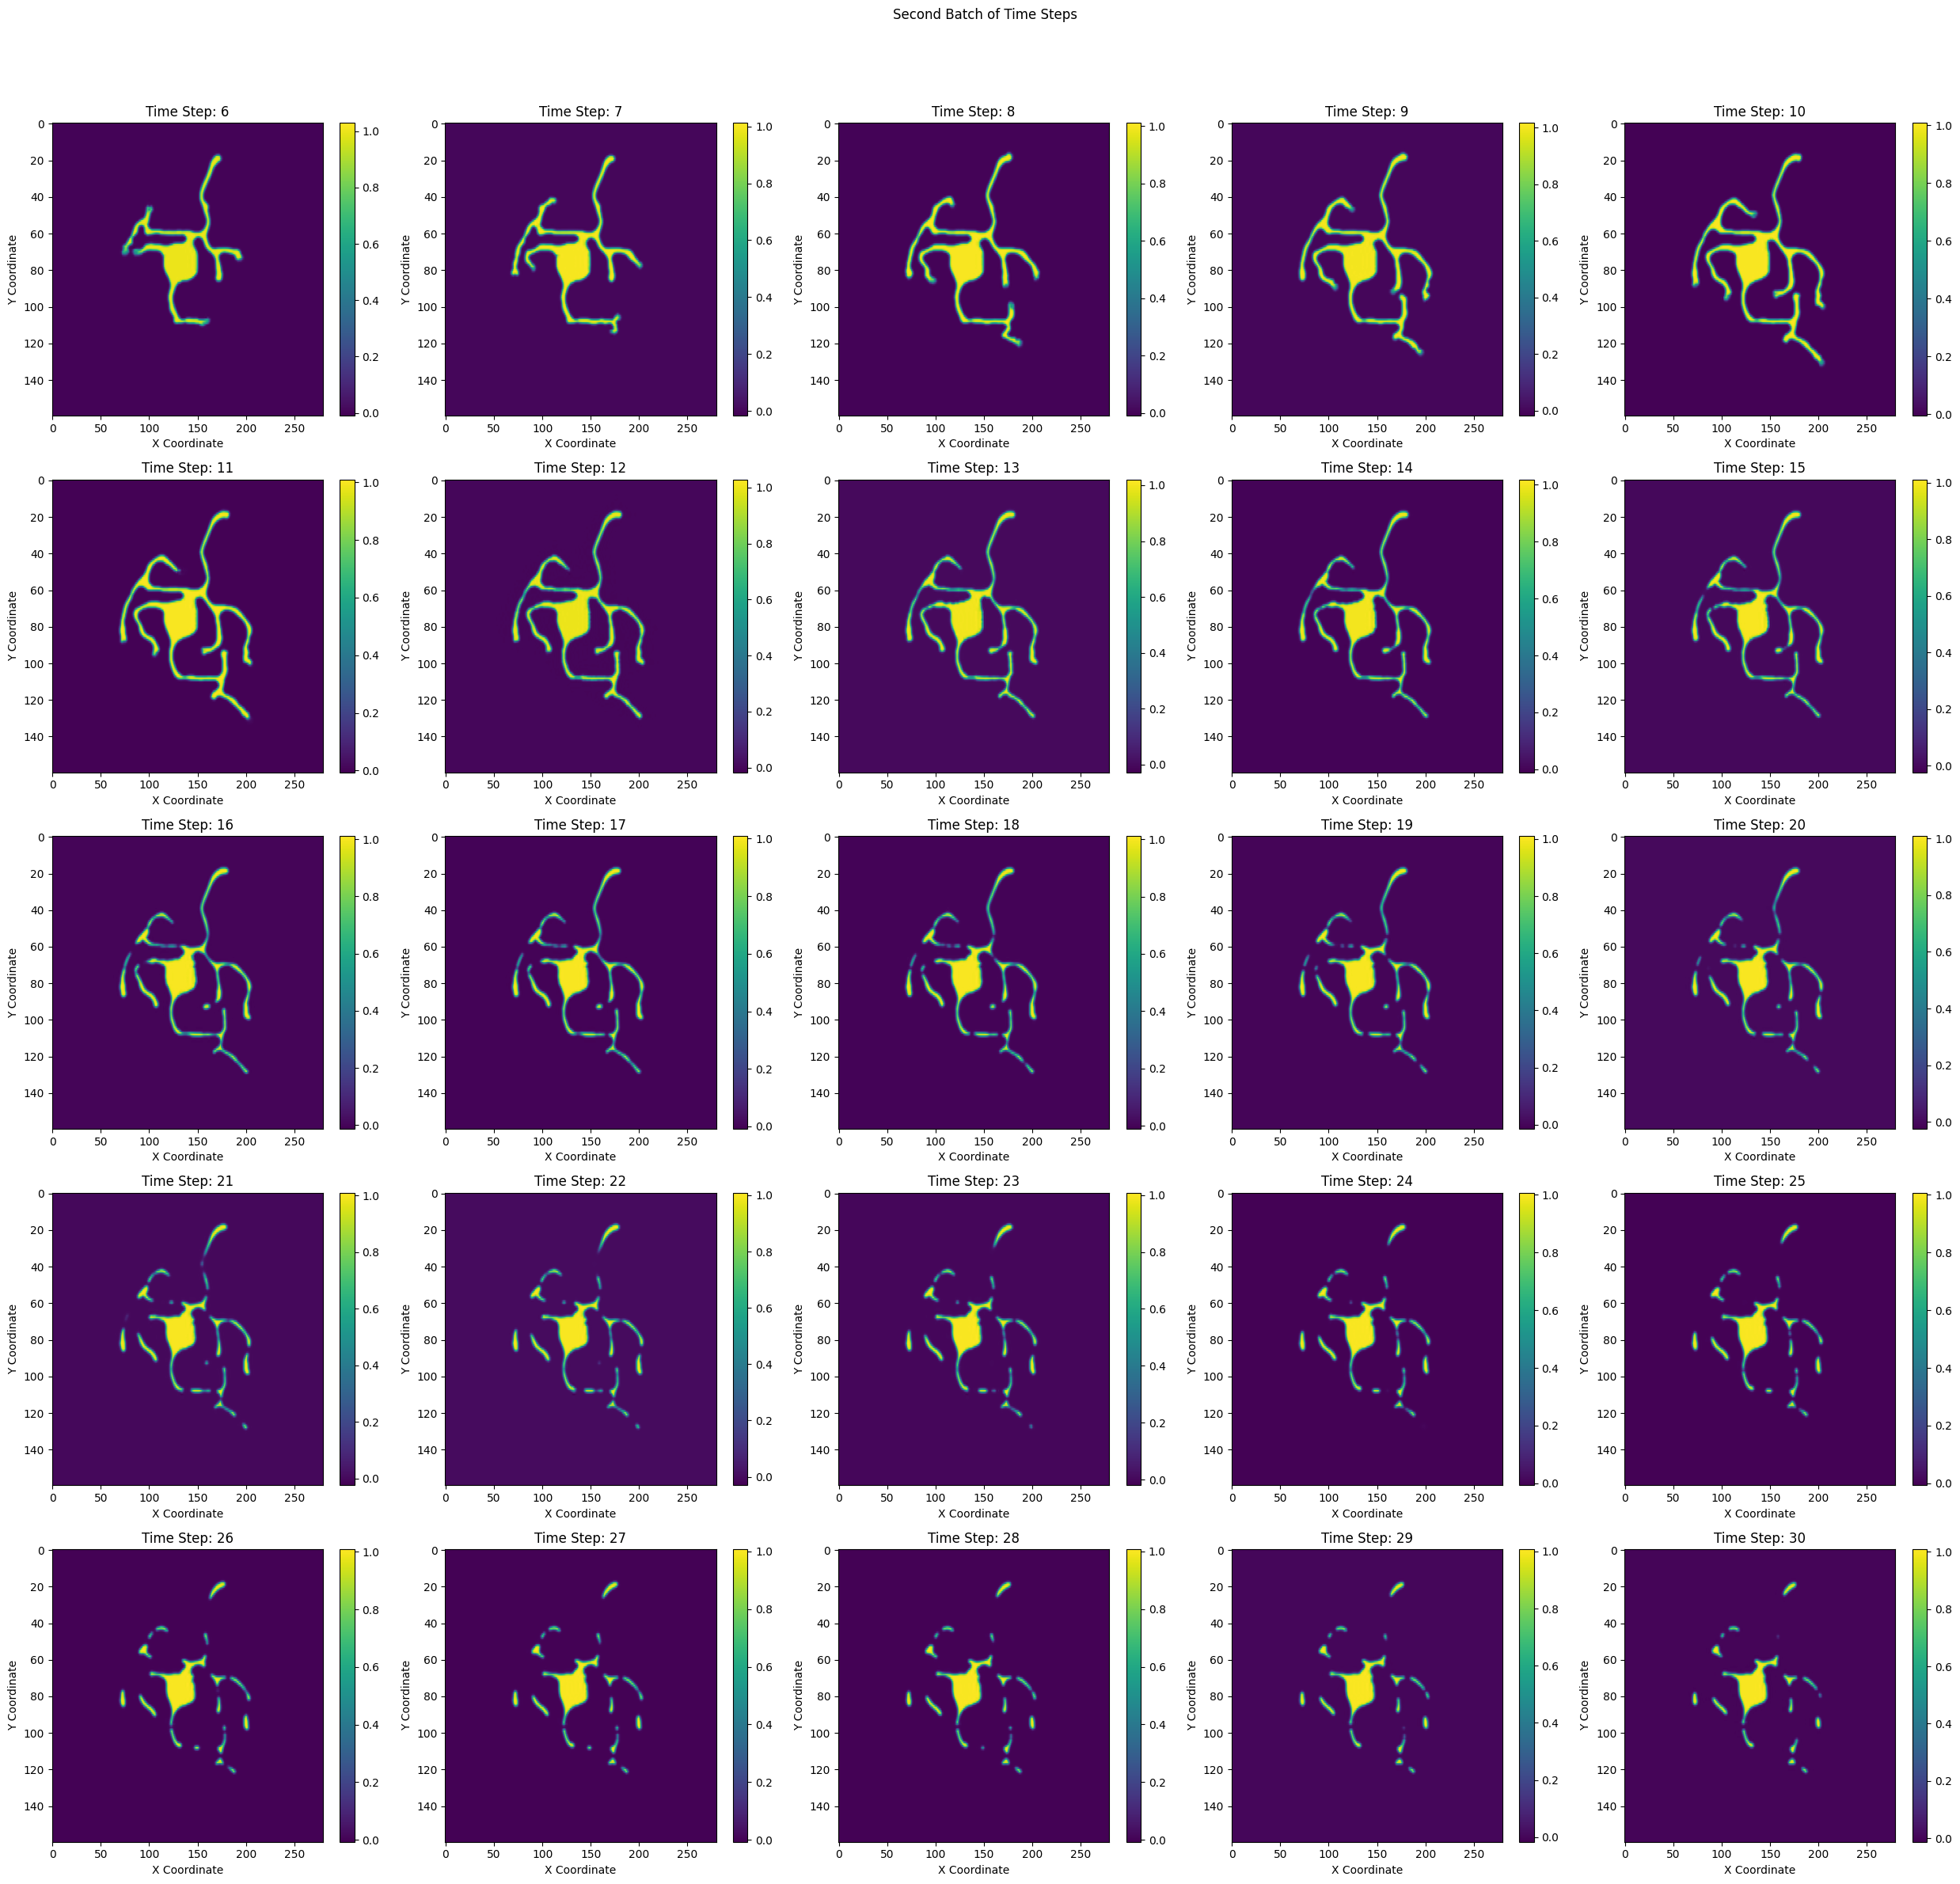

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_interpolated_time_steps(time_step_data, channel, split_at=5, columns_per_row=3):
    """
    Plots the specified channel from each time step's interpolated data, splitting the plots into two figures.

    Args:
        time_step_data (list of dicts): Each dict contains channel names as keys and 2D arrays of data as values.
        channel (str): Name of the channel to plot.
        split_at (int): Index at which to split the plots into a second figure.
        columns_per_row (int): Number of columns per row in the plot.

    Returns:
        None: Displays the plots.
    """
    
    num_time_steps = len(time_step_data)
    first_batch = min(num_time_steps, split_at)
    second_batch = num_time_steps - first_batch

    # Function to create plots for a given range of time steps
    def plot_batch(start_index, end_index, title):
        num_plots = end_index - start_index
        rows = (num_plots + columns_per_row - 1) // columns_per_row  # Calculate rows needed
        fig, axes = plt.subplots(rows, columns_per_row, figsize=(5 * columns_per_row, 5 * rows))
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])  # Handle the case where there is only one subplot
        axes = axes.flatten()

        for i in range(num_plots):
            ax = axes[i]
            data_index = start_index + i
            if channel in time_step_data[data_index]:
                c = ax.imshow(time_step_data[data_index][channel], cmap='viridis', aspect='auto')
                fig.colorbar(c, ax=ax)
                ax.set_title(f'Time Step: {data_index + 1}')
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
            else:
                ax.set_title(f'Channel {channel} not found')
                ax.set_xlabel('X Coordinate')
                ax.set_ylabel('Y Coordinate')
                print(f"Warning: Channel '{channel}' not found in time step {data_index + 1}.")

        for j in range(i + 1, len(axes)):  # Hide unused axes
            axes[j].axis('off')

        plt.suptitle(title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Plot the first batch of time steps
    plot_batch(0, first_batch, "First Batch of Time Steps")

    # Plot the second batch of time steps if there are any
    if second_batch > 0:
        plot_batch(first_batch, num_time_steps, "Second Batch of Time Steps")

# Randomly select a case key from all_cases_data
case_key = random.choice(list(all_cases_data.keys()))  # Randomly pick a case key
channel_to_plot = 'phi'  # Example channel to plot

# Now use the variable to access data and call the plotting function
plot_interpolated_time_steps(all_cases_data[case_key][0], channel_to_plot, columns_per_row=5)


In [16]:
import numpy as np
import random

def select_and_structure_data(all_cases_data, num_X_steps=10, num_Y_steps=20, train_frac=0.7, val_frac=0.15, channels=None):
    """
    Structured data extraction for ML training from multidimensional time-series data.

    Args:
        all_cases_data (dict): The main dataset containing all cases.
        num_X_steps (int): Number of time steps to use for X.
        num_Y_steps (int): Number of time steps to use for Y.
        train_frac (float): Fraction of data to be used for training.
        val_frac (float): Fraction of data to be used for validation.
        channels (list): List of channel names to include in the output arrays.

    Returns:
        dict: Dataset containing structured data for training, validation, and testing.
    """

    # Extract keys for all cases
    case_keys = list(all_cases_data.keys())
    random.shuffle(case_keys)

    # Determine split indices
    num_train = int(len(case_keys) * train_frac)
    num_val = int(len(case_keys) * val_frac)
    
    train_keys = case_keys[:num_train]
    val_keys = case_keys[num_train:num_train + num_val]
    test_keys = case_keys[num_train + num_val:]

    # Define function to extract data for X and Y
    def extract_data(cases, num_X_steps, num_Y_steps, channels):
        X, Y = [], []
        for case in cases:
            case_data = all_cases_data[case][0]  # Assuming the data structure is (list of dicts with channel data, grid_x, grid_y)
            # print(case_data)
            print(case)
            case_data[0]['phi']
            if len(case_data) >= num_X_steps + num_Y_steps:
                x_segments = np.stack([np.array([time_step[channel] for time_step in case_data[:num_X_steps]]) for channel in channels if channel in case_data[0]], axis=1)
                y_segments = np.stack([np.array([time_step[channel] for time_step in case_data[num_X_steps:num_X_steps + num_Y_steps]]) for channel in channels if channel in case_data[0]], axis=1)

                X.append(x_segments)
                Y.append(y_segments)

        return np.array(X), np.array(Y)

    # Extract data for each dataset
    X_train, Y_train = extract_data(train_keys, num_X_steps, num_Y_steps, channels)
    X_val, Y_val = extract_data(val_keys, num_X_steps, num_Y_steps, channels)
    X_test, Y_test = extract_data(test_keys, num_X_steps, num_Y_steps, channels)

    return {
        'X_train': X_train, 'Y_train': Y_train,
        'X_val': X_val, 'Y_val': Y_val,
        'X_test': X_test, 'Y_test': Y_test
    }

# Example usage: specify which channels to include
# channels_to_include = ['phi', 'synaptogenesis', 'tubulin', 'tips', 'theta']  # Add your specific channels here
channels_to_include = ['phi']  # Add your specific channels here
dataset = select_and_structure_data(all_cases_data, channels=channels_to_include)

# Display the shapes of the datasets
for key in dataset:
    print(f"{key} shape: {dataset[key].shape if dataset[key].size else 'Empty'}")

io2D_ND07
io2D_ND05
io2D_ND09
io2D_ND06
io2D_ND04
io2D_ND01
io2D_ND03
io2D_ND08
X_train shape: (5, 10, 1, 160, 280)
Y_train shape: (5, 20, 1, 160, 280)
X_val shape: (1, 10, 1, 160, 280)
Y_val shape: (1, 20, 1, 160, 280)
X_test shape: (2, 10, 1, 160, 280)
Y_test shape: (2, 20, 1, 160, 280)


In [17]:
import pickle

# Save the dataset to a .pkl file using pickle
with open('./reformatedNDDs/dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)